In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import mediapipe as mp

import plotly.graph_objects as go

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV

import xgboost as xgb

import joblib

In [10]:
model_path = './hand_landmarker.task'

In [11]:
df = pd.read_csv('./versions/dataset_xyz.csv')
df.head()

,label,keypoints
0,A,"[(0.5160611271858215, 0.7950515747070312, -7.2..."
1,A,"[(0.5043174028396606, 0.7688353061676025, -3.6..."
2,A,"[(0.5133167505264282, 0.8641117811203003, -4.2..."
3,A,"[(0.5338877439498901, 0.7778040766716003, -6.5..."
4,A,"[(0.5210541486740112, 0.8094577789306641, -7.5..."


In [12]:
image = eval(df.loc[0, 'keypoints'])

# Extract x, y, and z coordinates from image
x = [coord[0] for coord in image]
y = [coord[1] for coord in image]
z = [coord[2] for coord in image]

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=5))])

# Add lines connecting the points
fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='lines', line=dict(color='blue', width=2)))

# Set labels and title
fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'), title='3D Plot of Coordinates')

# Show the plot
fig.show()


In [13]:
joint_list = [[4,3,2], [8,7,6], [12,11,10], [16,15,14], [20,19,18]]

In [14]:
def draw_finger_angles(keypoints, joint_list):
    list_angles = []
    for joint in joint_list:
        a = keypoints[joint[0]]
        b = keypoints[joint[1]]
        c = keypoints[joint[2]]
        radians = np.arctan2(c[1] - b[1], c[0] - b[0]) - np.arctan2(a[1] - b[1], a[0] - b[0])
        angle = np.abs(radians * 180.0 / np.pi)
        if angle > 180.0:
            angle = 360 - angle
        list_angles.append(angle)
    return list_angles

In [15]:
# Iterate over the rows of the dataframe
for index, row in df.iterrows():
    keypoints = eval(row['keypoints'])
    angles = draw_finger_angles(keypoints, joint_list)
    
    # Add the angles as new columns to the dataframe
    for i, angle in enumerate(angles):
        column_name = f'Angle_{i+1}'
        df.loc[index, column_name] = angle


In [16]:
df.head()

,label,keypoints,Angle_1,Angle_2,Angle_3,Angle_4,Angle_5
0,A,"[(0.5160611271858215, 0.7950515747070312, -7.2...",168.064241,170.749289,172.299434,173.483256,171.859274
1,A,"[(0.5043174028396606, 0.7688353061676025, -3.6...",173.490061,178.698236,179.537005,179.986749,178.034921
2,A,"[(0.5133167505264282, 0.8641117811203003, -4.2...",169.506552,169.982852,171.867547,169.729956,165.238714
3,A,"[(0.5338877439498901, 0.7778040766716003, -6.5...",178.123659,162.300432,164.233809,163.050348,146.869520
4,A,"[(0.5210541486740112, 0.8094577789306641, -7.5...",179.247352,170.643276,175.673820,173.457268,163.117709


In [17]:
class_counts = df['label'].value_counts()
print(class_counts)

label
H        715
C        713
G        659
U        644
T        638
N        630
J        627
A        621
K        608
L        606
R        580
B        560
O        538
W        536
Q        524
F        519
I        515
Z        491
P        482
V        475
Y        469
D        458
X        455
S        436
E        433
M        427
Blank      1
Name: count, dtype: int64


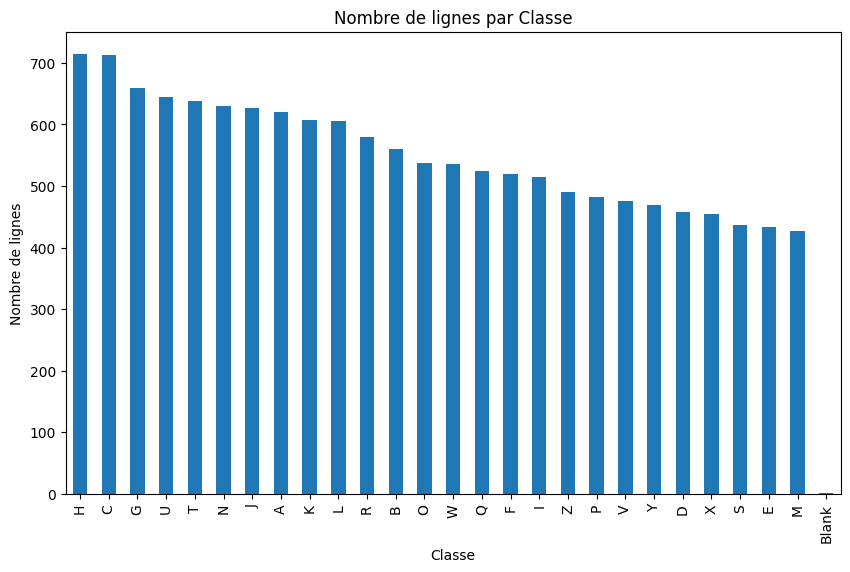

In [18]:
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.xlabel('Classe')
plt.ylabel('Nombre de lignes')
plt.title('Nombre de lignes par Classe')
plt.show()

In [19]:
num_rows_M = len(df[df['label'] == 'M'])
print(num_rows_M)

427


In [20]:
seuil_bas = 25
seuil_haut = 427

classes_to_keep = class_counts[class_counts >= seuil_bas].index
df_filtered = pd.DataFrame(columns=df.columns)
for classe in classes_to_keep:
    df_classe = df[df['label'] == classe]
    if len(df_classe) > seuil_haut:
        df_classe = df_classe.head(seuil_haut)
    df_filtered = pd.concat([df_filtered, df_classe], ignore_index=True)

df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11102 entries, 0 to 11101
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   label      11102 non-null  object 
 1   keypoints  11102 non-null  object 
 2   Angle_1    11102 non-null  float64
 3   Angle_2    11102 non-null  float64
 4   Angle_3    11102 non-null  float64
 5   Angle_4    11102 non-null  float64
 6   Angle_5    11102 non-null  float64
dtypes: float64(5), object(2)
memory usage: 607.3+ KB


C:\Users\m.baffoigne\AppData\Local\Temp\ipykernel_9928\1021843465.py:10: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



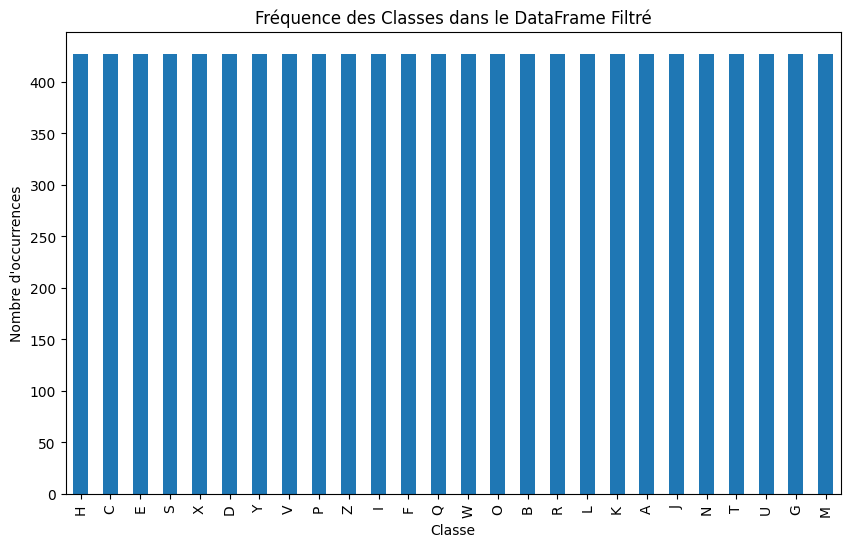

In [21]:
class_counts_filtered = df_filtered['label'].value_counts()

plt.figure(figsize=(10, 6))
class_counts_filtered.plot(kind='bar')
plt.xlabel('Classe')
plt.ylabel('Nombre d\'occurrences')
plt.title('Fréquence des Classes dans le DataFrame Filtré')
plt.show()

In [22]:
def transform_tuples(row):
    keypoints = eval(row)
    return [coord for point in keypoints for coord in point]
df_filtered['keypoints'] = df_filtered['keypoints'].apply(transform_tuples)
print(df_filtered.head())

  label                                          keypoints     Angle_1  \
0     H  [0.4206766188144684, 0.610883355140686, 2.3337...  146.941762   
1     H  [0.3816889822483063, 0.6490432620048523, 1.525...  172.405865   
2     H  [0.6095360517501831, 0.6253103613853455, 3.136...  160.247280   
3     H  [0.604487955570221, 0.6316844820976257, 3.0319...  164.625646   
4     H  [0.3648202419281006, 0.6226154565811157, 4.443...  162.604346   

      Angle_2     Angle_3     Angle_4     Angle_5  
0  168.484127  168.323694  170.637537  175.106490  
1  177.418176  172.934411  145.935090  145.748094  
2  175.541508  178.660258  143.175551  139.050996  
3  173.799883  179.382315  157.805133  158.959287  
4  167.962832  169.131960  162.318180  168.596012  


In [23]:
X = pd.DataFrame(df_filtered['keypoints'].tolist())
y = df_filtered['label']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
models = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC(),
    KNeighborsClassifier()
]

for model in models:
    scores = cross_val_score(model, X_train, y_train, cv=5) 
    print(f"Model: {type(model).__name__}")
    print(f"Cross-validation scores: {scores}")
    print(f"Mean score: {scores.mean()}")
    print(f"Standard deviation: {scores.std()}")

c:\Users\m.baffoigne\Documents\Dev\project\asl_web_app\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

c:\Users\m.baffoigne\Documents\Dev\project\asl_web_app\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

Model: LogisticRegression
Cross-validation scores: [0.98030388 0.95720721 0.97240991 0.97635135 0.97072072]
Mean score: 0.9713986144275959
Standard deviation: 0.00783213518519405
Model: DecisionTreeClassifier
Cross-validation scores: [0.99043331 0.98704955 0.98536036 0.99268018 0.98986486]
Mean score: 0.9890776539060162
Standard deviation: 0.0025832998697340607
Model: RandomForestClassifier
Cross-validation scores: [0.99606078 0.99380631 0.99493243 0.99718468 0.99774775]
Mean score: 0.9959463895521858
Standard deviation: 0.0014421800108340116
Model: SVC
Cross-validation scores: [0.98874508 0.97747748 0.98423423 0.98367117 0.9847973 ]
Mean score: 0.9837850512301834
Standard deviation: 0.003622891337373702
Model: KNeighborsClassifier
Cross-validation scores: [0.99549803 0.99211712 0.99774775 0.99605856 0.99774775]
Mean score: 0.9958338403118934
Standard deviation: 0.0020641405595451406


In [26]:
model_xgb = xgb.XGBClassifier()
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

scores = cross_val_score(model_xgb, X_train, y_train_encoded, cv=5)

print(f"Model: {type(model_xgb).__name__}")
print(f"Cross-validation scores: {scores}")
print(f"Mean score: {scores.mean()}")
print(f"Standard deviation: {scores.std()}")

Model: XGBClassifier
Cross-validation scores: [0.99437254 0.99380631 0.99718468 0.99605856 0.99211712]
Mean score: 0.9947078409304071
Standard deviation: 0.001766139049693121


In [27]:
model_xgb = xgb.XGBClassifier()
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

param_grid = {
    'max_depth': 7,
    'learning_rate': 0.1,
    'n_estimators': 300,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

model_xgb.set_params(**param_grid)
model_xgb.fit(X_train, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [28]:
y_pred = model_xgb.predict(X_test)
report = classification_report(y_test_encoded, y_pred)
cm = confusion_matrix(y_test_encoded, y_pred)
print("Rapport de classification :")
print(report)

Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        98
           1       0.99      1.00      0.99        84
           2       1.00      1.00      1.00        91
           3       1.00      1.00      1.00        87
           4       0.99      0.99      0.99        69
           5       1.00      0.97      0.98        86
           6       1.00      1.00      1.00        80
           7       1.00      1.00      1.00        93
           8       1.00      1.00      1.00        79
           9       1.00      1.00      1.00        72
          10       1.00      0.99      0.99        87
          11       0.98      1.00      0.99        99
          12       1.00      0.97      0.98       100
          13       0.98      1.00      0.99        86
          14       1.00      1.00      1.00        90
          15       1.00      1.00      1.00        86
          16       1.00      1.00      1.00        83

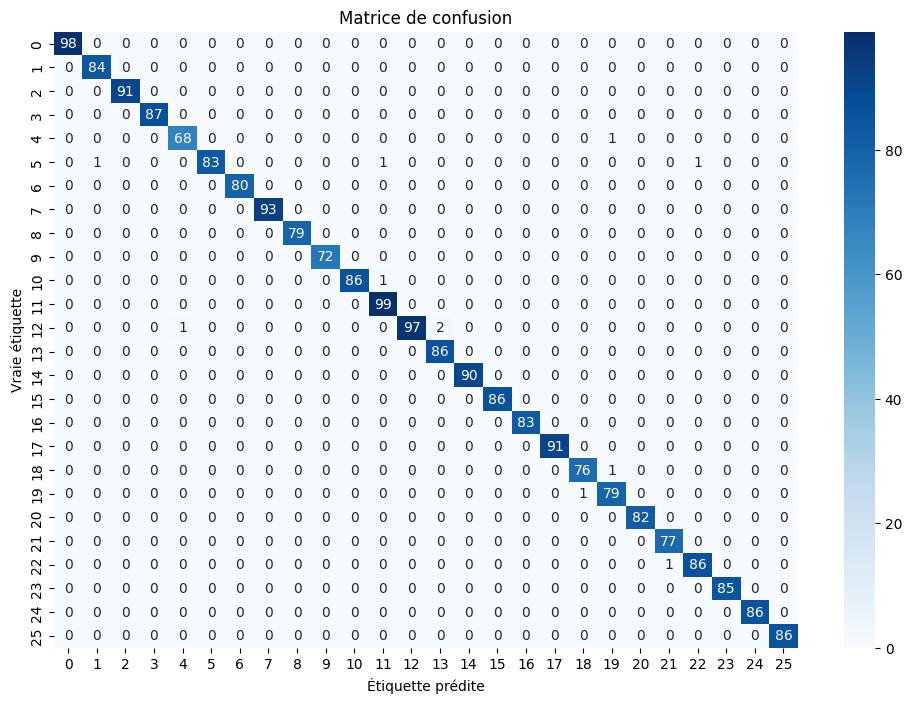

In [29]:
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.ylabel('Vraie étiquette')
plt.xlabel('Étiquette prédite')
plt.title('Matrice de confusion')
plt.show()

In [30]:
joblib.dump(model_xgb, 'model_xgb_xyz_angles_v1.pkl')

['model_xgb_xyz_angles_v1.pkl']